## Comparison of the four trained models

The following notebook has been used to generate the comparison image found in the report

#### Imports and functions

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import wandb
from model import TextureSynthesizer

In [70]:
# Generate example images (replace this with your image data)
def plot_images(images, labels, num_images=6):


    # Set up the figure
    fig, axes = plt.subplots(2, 3, figsize=(5, 3))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    # Plot images and labels
    for i in range(2):
        for j in range(3):
            idx = i * 3 + j
            if idx < num_images:
                axes[i, j].imshow(images[idx], cmap="hot")
                axes[i, j].set_title(labels[idx], fontsize=10)
                axes[i, j].axis('off')

    # Hide empty subplots
    for i in range(num_images, 6):
        axes[i // 3, i % 3].axis('off')


    plt.tight_layout()

    plt.show()


#### Downloading the model artifacts

In [71]:
api = wandb.Api()

# Download wandb artifacts

# VGG Encoder + Gram
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v4')
artifact.download()

# NVIDIA Encoder + Gram
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v1')
artifact.download()

# VGG Encoder + Wasserstein
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v5')
artifact.download()

# NVIDIA Encoder + Wasserstein 
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v3')
artifact.download()

wandb: Downloading large artifact model:v4, 426.11MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact model:v1, 419.52MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact model:v5, 426.11MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact model:v3, 419.52MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


'./artifacts/model:v3'

#### Models initialization

In [44]:
def get_dict(path):
    state_dict = torch.load(path)
    state_dict_copy = dict(state_dict)
    for key in state_dict.keys():   # iter on both keys and values
        if key.startswith('fid.inception') or key.startswith('vgg.features'):
            state_dict_copy.pop(key, None)
    return state_dict_copy

In [45]:
dict_vgg_enc_gram = get_dict("artifacts/model:v4/model_weights_599.pth")
dict_nvidia_enc_gram = get_dict("artifacts/model:v1/model_weights_599.pth")
dict_nvidia_enc_wasserstein = get_dict("artifacts/model:v3/model_weights_599.pth")
dict_vgg_enc_wasserstein = get_dict("artifacts/model:v5/model_weights_599.pth")

In [46]:
model_vgg_enc_gram = TextureSynthesizer(64, 64, encoder_type="vgg").to(device="cuda")
model_nvidia_enc_gram = TextureSynthesizer(64, 64, encoder_type="default").to(device="cuda")
model_nvidia_enc_wasserstein = TextureSynthesizer(64, 64, encoder_type="default").to(device="cuda")
model_vgg_enc_wasserstein = TextureSynthesizer(64, 64, encoder_type="vgg").to(device="cuda")

/home/antonio/miniconda3/envs/dlai-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/antonio/miniconda3/envs/dlai-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
model_vgg_enc_gram.load_state_dict(dict_vgg_enc_gram)
model_nvidia_enc_gram.load_state_dict(dict_nvidia_enc_gram)
model_nvidia_enc_wasserstein.load_state_dict(dict_nvidia_enc_wasserstein)
model_vgg_enc_wasserstein.load_state_dict(dict_vgg_enc_wasserstein)

model_vgg_enc_gram.eval()
model_nvidia_enc_gram.eval()
model_nvidia_enc_wasserstein.eval()
model_vgg_enc_wasserstein.eval()

TextureSynthesizer(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplac

#### Forward passes

In [48]:
models = [model_vgg_enc_gram, model_nvidia_enc_gram, model_nvidia_enc_wasserstein, model_vgg_enc_wasserstein]

In [49]:
from PIL import Image

test = Image.open("test.png").convert('RGB')

In [50]:
from torchvision import transforms
x_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

x = x_transform(test).unsqueeze(0).to(device="cuda")


In [51]:
y_batch = [model(x).squeeze(0).detach().cpu().permute(1,2,0).numpy() for model in models]

/home/antonio/miniconda3/envs/dlai-env/lib/python3.11/site-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


#### Final comparison

/home/antonio/miniconda3/envs/dlai-env/lib/python3.11/site-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


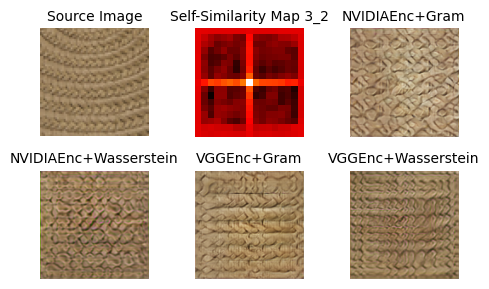

In [73]:
image_shape = (256, 256, 3)
num_images = 6

images = [np.random.randint(0, 256, size=image_shape, dtype=np.uint8) for _ in range(num_images)]
labels = ["Source Image", "Self-Similarity Map 3_2", "NVIDIAEnc+Gram", "NVIDIAEnc+Wasserstein", "VGGEnc+Gram", "VGGEnc+Wasserstein"]

models = [model_vgg_enc_gram, model_nvidia_enc_gram, model_nvidia_enc_wasserstein]


ssl_1, ssl_2, ssl_3 = model_nvidia_enc_gram.get_self_similarity(x)

self_sim_maps =[ img.squeeze(0).detach().cpu().permute(1,2,0).numpy()  for img in [ssl_1, ssl_2, ssl_3] ]

images[0] = test
images[1] =  self_sim_maps[2]

images[2]  = y_batch[1]
images[5] = y_batch[3]
images[4] = y_batch[0]
images[3] = y_batch[2]

plot_images(images, labels, num_images=6)